In [9]:
import numpy as np
import pyuvdata
import matplotlib.pyplot as plt
import matplotlib


In [2]:
model_path = "/Users/ruby/Astro/fhd_rlb_model_GLEAM_bright_sources_Jun2022"
model_use_model = True
data_path = "/Users/ruby/Astro/fhd_rlb_model_GLEAM_Jun2022"
data_use_model = True
obsid = "1061316296"
pol = "XX"
use_autos = False

In [3]:
data = pyuvdata.UVData()
data.read_fhd(
    [
        f"{data_path}/vis_data/{obsid}_vis_model_XX.sav",
        f"{data_path}/vis_data/{obsid}_vis_model_YY.sav",
    ],
    params_file=f"{data_path}/metadata/{obsid}_params.sav",
    flags_file=f"{data_path}/vis_data/{obsid}_flags.sav",
    layout_file=f"{data_path}/metadata/{obsid}_layout.sav",
)

The settings_file parameter was not passed, so some history information will be missing.
Using experimental 64-bit array read
Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
tile_names from obs structure does not match antenna_names from layout
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 5.453493568058933, largest imaginary/real ratio was 0.002758751306136586.


In [4]:
model = pyuvdata.UVData()
model.read_fhd(
    [
        f"{model_path}/vis_data/{obsid}_vis_model_XX.sav",
        f"{model_path}/vis_data/{obsid}_vis_model_YY.sav",
    ],
    params_file=f"{model_path}/metadata/{obsid}_params.sav",
    flags_file=f"{model_path}/vis_data/{obsid}_flags.sav",
    layout_file=f"{model_path}/metadata/{obsid}_layout.sav",
)

The settings_file parameter was not passed, so some history information will be missing.


Using experimental 64-bit array read
Telescope location derived from obs lat/lon/alt values does not match the location in the layout file. Using the value from known_telescopes.
tile_names from obs structure does not match antenna_names from layout
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array. Largest imaginary component was 7.827296022245892, largest imaginary/real ratio was 0.004182939709460622.


In [5]:
diff = data.sum_vis(model, difference=True)

In [6]:
del data
del model

In [24]:
bl_lengths = np.sqrt(np.sum(diff.uvw_array**2.0, axis=1))
nbins = 300
bl_bin_edges = np.linspace(np.min(bl_lengths), np.max(bl_lengths), num=nbins + 1)

use_data = np.copy(diff.data_array[:, :, 0])
use_flags = np.copy(diff.flag_array[:, :, 0])
baseline_all_flagged = np.min(
    use_flags, axis=(1,)
)  # Note what baselines are fully flagged
use_data[np.where(use_flags)] = np.nan  # Zero out flagged data

binned_variance = np.full(
    [len(bl_bin_edges) - 1, diff.Nfreqs], np.nan, dtype="float"
)
nsamples = np.full([len(bl_bin_edges) - 1, diff.Nfreqs], 0.0, dtype="float")
for bin_ind in range(len(bl_bin_edges) - 1):
    bl_inds = np.where(
        (bl_lengths > bl_bin_edges[bin_ind])
        & (bl_lengths <= bl_bin_edges[bin_ind + 1])
        & (~baseline_all_flagged)
    )[0]
    if len(bl_inds) > 0:
        binned_variance[bin_ind, :] = np.nansum(np.abs(use_data[bl_inds, :]) ** 2.0, axis=0)
        nsamples[bin_ind, :] = len(bl_inds)

avg_power = binned_variance / nsamples

In [29]:
np.min(avg_power)

nan

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


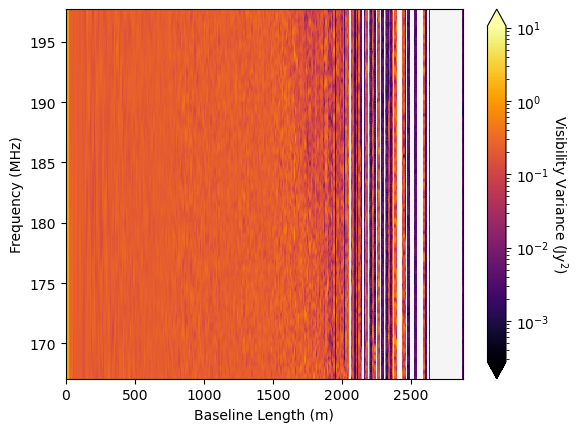

In [31]:
use_cmap = matplotlib.cm.get_cmap("inferno").copy()
use_cmap.set_bad(color="whitesmoke")
plt.imshow(
    avg_power.T,
    origin="lower",
    interpolation="none",
    cmap=use_cmap,
    extent=[
        np.min(bl_bin_edges),
        np.max(bl_bin_edges),
        np.min(diff.freq_array) / 1e6,
        np.max(diff.freq_array) / 1e6,
    ],
    aspect="auto",
    norm=matplotlib.colors.LogNorm(
        vmin=np.nanmin(avg_power), vmax=np.nanmax(avg_power)
    ),
)
cbar = plt.colorbar(extend="both")
cbar.ax.set_ylabel(
    "Visibility Variance (Jy$^{2}$)", rotation=270, labelpad=15
)
plt.xlabel("Baseline Length (m)")
plt.ylim([np.min(diff.freq_array) / 1e6, np.max(diff.freq_array) / 1e6])
plt.ylabel("Frequency (MHz)")
plt.savefig("/Users/ruby/Downloads/visibility_error_frequency.png", dpi=600)
plt.show()